In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from math import sqrt
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
import shap

## Data preparation

In [2]:
df = pd.read_csv('dataset\no_corr_qtaim_pt_dataset.csv')

In [3]:
y = df.Shift.to_numpy()
X = df.drop(['Complex ID', 'Shift', 'Source_doi', 'Brutto', 'Charge_class', 'Geometry', 'Ligand', 'Smiles'], axis=1)
columns = X.columns
X = X.to_numpy()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
scaler_train = StandardScaler()

scaler_train.fit(X_train)
scaler_train.fit(X_test)

X_train_norm = scaler_train.transform(X_train)
X_test_norm = scaler_train.transform(X_test)

## Some useful functions

In [6]:
def metrics(y, y_pred):
    
    rmse = sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print('RMSE = {:0.2f} ppm'.format(rmse),'\n',
          'MAE = {:0.2f} ppm'.format(mae), '\n',
         '$R**2$ = {:0.2f}'.format(r2))   
    return {'RMSE': rmse, 'MAE': mae, '$R^2$': r2}

In [7]:
def plot_correlation(model, X, y):
    plt.rcParams['font.size'] = 16
    fig, ax = plt.subplots(figsize=(6,6))
    plt.plot(y, y, color='r', linestyle='-', linewidth=2)
    plt.plot(y, model.predict(X), linestyle='none', color='blue', marker='o')
    
    
    plt.xlabel("Experimental δ, ppm")
    plt.ylabel("Predicted δ, ppm")
    plt.show()
#     fig.savefig('{}.png'.format(model), dpi=300, bbox_inches = 'tight')
    
    return metrics(y, model.predict(X))

In [8]:
def tune_hyperparam(estimator, grid, X, y):
    
    est_random = RandomizedSearchCV(estimator=estimator, param_distributions = grid, n_iter = 100, 
                                    cv = 5, verbose=2, random_state=42, n_jobs = -1)
    est_random.fit(X, y)
    print(est_random.best_params_)
    print('Mean of $R**2$', est_random.best_score_)
    
    return est_random.best_estimator_

In [9]:
def evaluate(estimator, X, y, n_splits, scoring):
    
    cv = ShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)
    scores = cross_val_score(estimator, X, y, cv=cv, scoring=scoring)
    
    if scoring == 'r2':
        scores = scores
        
    if scoring == 'neg_mean_absolute_error':
        scores = [-i for i in scores]
        
    if scoring == 'neg_mean_squared_error':
        scores = [np.sqrt(-i) for i in scores]
        
    return {'Mean':np.round(np.mean(scores), 2), 'Std': np.round(np.std(scores), 2),
            'Min': np.round(np.min(scores), 2), 'Max': np.round(np.max(scores), 2)}

## Models: Random Forest, Ridge regressor, SVR

### Hyperprameter tuning by use of grid search

In [10]:
#Random forest grid
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 20)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 205, num = 22)]
max_depth.append(None)
min_samples_split = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
min_samples_leaf = [1, 2, 3, 4]
bootstrap = [True, False]
warm_start = [True, False]
grid_rf = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'warm_start': warm_start}

In [11]:
#Ridge regression grid
alpha = [1.e-0, 1.e-1, 1.e-2, 1.e-3, 1.e-4, 1.e-5, 1.e-6, 1.e-7, 1.e-8, 1.e-9, 1.e-10]
coef0 = np.linspace(1.e-10, 1, 50)
degree = [0, 1, 2, 3, 4]
gamma = [1.e-0, 1.e-1, 1.e-2, 1.e-3, 1.e-4, 1.e-5, 1.e-6, 1.e-7, 1.e-8, 1.e-9, 1.e-10]
kernel = ['laplacian', 'RBF', 'polynomial', 'exponential chi2', 'sigmoid']

grid_ridge = {'alpha': alpha,
         'coef0': coef0,
         'degree': degree,
         'gamma': gamma,
         'kernel': kernel}

In [12]:
#SVR grid
C = [10000, 100000, 1000000, 10000000]
coef0 = [1.e-0, 1.e-1, 1.e-2, 1.e-3, 1.e-4, 1.e-5, 1.e-6, 1.e-7, 1.e-8, 1.e-9, 1.e-10]
degree = [1, 2, 3, 4, 5]
epsilon = [1.e-0, 1.e-1, 1.e-2, 1.e-3, 1.e-4, 1.e-5, 1.e-6, 1.e-7, 1.e-8, 1.e-9, 1.e-10]
gamma = ['scale', 'auto']
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
tol = [1.e-1, 1.e-2, 1.e-3, 1.e-4, 1.e-5, 1.e-6, 1.e-7, 1.e-8, 1.e-9, 1.e-10]
max_iter = 1000000

grid_svr = {'C' : C,
     'coef0': coef0,
     'degree': degree,
     'epsilon': epsilon,
     'gamma': gamma,
     'kernel': kernel,
     'tol': tol}

In [13]:
rf = RandomForestRegressor(random_state=42)
ridge = KernelRidge()
svr = SVR(max_iter=max_iter)
estimators = {rf: grid_rf, ridge: grid_ridge, svr: grid_svr}

In [14]:
best_estim = []
for i, j in estimators.items():
    best_estim.append(tune_hyperparam(i, j, X_train_norm, y_train))

Fitting 5 folds for each of 100 candidates, totalling 500 fits



40 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\evg_ondar\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\evg_ondar\Miniconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "C:\Users\evg_ondar\Miniconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\evg_ondar\Miniconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File 

{'warm_start': True, 'n_estimators': 322, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 33, 'bootstrap': True}
Mean of $R**2$ 0.9404376620345621
Fitting 5 folds for each of 100 candidates, totalling 500 fits



185 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
110 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\evg_ondar\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\evg_ondar\Miniconda3\lib\site-packages\sklearn\kernel_ridge.py", line 186, in fit
    K = self._get_kernel(X)
  File "C:\Users\evg_ondar\Miniconda3\lib\site-packages\sklearn\kernel_ridge.py", line 154, in _get_kernel
    return pairwise_kernels(X, Y, metric=self.kernel, filter_params=True, **params)
  File "C:\Users\evg_ondar\Miniconda3\lib\site-packages\sklearn\metrics\pairwise.py", lin

{'kernel': 'polynomial', 'gamma': 0.001, 'degree': 3, 'coef0': 0.30612244904897956, 'alpha': 1e-06}
Mean of $R**2$ 0.9835794389201868
Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'tol': 1e-10, 'kernel': 'poly', 'gamma': 'scale', 'epsilon': 1e-09, 'degree': 3, 'coef0': 1.0, 'C': 1000000}
Mean of $R**2$ 0.9936045433910883


Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


In [15]:
best_estim

[RandomForestRegressor(max_depth=33, max_features='auto', min_samples_split=3,
                       n_estimators=322, random_state=42, warm_start=True),
 KernelRidge(alpha=1e-06, coef0=0.30612244904897956, gamma=0.001,
             kernel='polynomial'),
 SVR(C=1000000, coef0=1.0, epsilon=1e-09, kernel='poly', max_iter=1000000,
     tol=1e-10)]

### Training and evaluation of models by use of cross-validation

In [16]:
print('Range of chem shifts', np.min(y_train), ':', np.max(y_train))

Range of chem shifts -6293 : 7090


In [17]:
#Determination coefficient
res_r2 = []
for i in best_estim:
    res_r2.append(evaluate(i, X_train_norm, y_train, n_splits=4, scoring='r2'))
res_df_r2 = pd.DataFrame(res_r2, index=['RF', 'Ridge regr', 'SVR'])
res_df_r2

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
Solv

,Mean,Std,Min,Max
RF,0.96,0.01,0.95,0.98
Ridge regr,0.99,0.01,0.99,1.00
SVR,0.99,0.01,0.98,1.00


In [18]:
#MAE
res_mae = []
for i in best_estim:
    res_mae.append(evaluate(i, X_train_norm, y_train, n_splits=4, scoring='neg_mean_absolute_error'))
res_df_mae = pd.DataFrame(res_mae, index=['RF', 'Ridge regr', 'SVR'])
res_df_mae

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
Solv

,Mean,Std,Min,Max
RF,359.65,70.99,254.16,431.97
Ridge regr,141.64,43.73,92.34,198.60
SVR,185.94,45.13,117.85,228.35


In [19]:
#RMSE
res_rmse = []
for i in best_estim:
    res_rmse.append(evaluate(i, X_train_norm, y_train, n_splits=4, scoring='neg_mean_squared_error'))
res_df_rmse = pd.DataFrame(res_rmse, index=['RF', 'Ridge regr', 'SVR'])
res_df_rmse

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
Solv

,Mean,Std,Min,Max
RF,549.14,139.10,331.73,696.39
Ridge regr,212.10,87.43,133.20,348.76
SVR,270.21,83.37,167.84,395.46


RandomForestRegressor(max_depth=33, max_features='auto', min_samples_split=3,
                      n_estimators=322, random_state=42, warm_start=True)


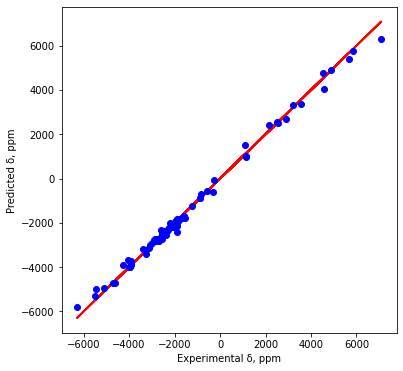

RMSE = 190.00 ppm 
 MAE = 125.07 ppm 
 $R**2$ = 0.99


KernelRidge(alpha=1e-06, coef0=0.30612244904897956, gamma=0.001,
            kernel='polynomial')


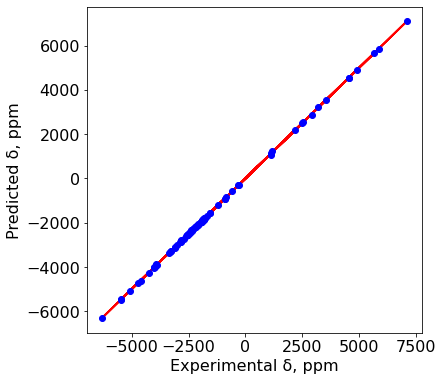

RMSE = 22.11 ppm 
 MAE = 14.23 ppm 
 $R**2$ = 1.00


SVR(C=1000000, coef0=1.0, epsilon=1e-09, kernel='poly', max_iter=1000000,
    tol=1e-10)


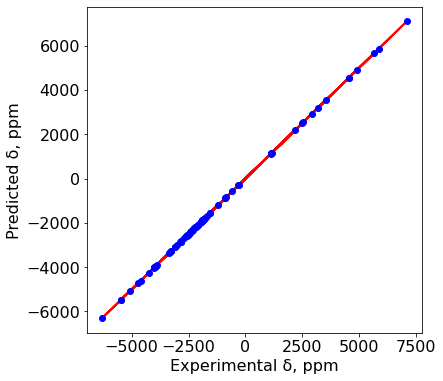

RMSE = 0.08 ppm 
 MAE = 0.01 ppm 
 $R**2$ = 1.00




In [20]:
for i in best_estim:
    print(i)
    plot_correlation(i, X_train_norm, y_train,)
    print('\n')

RandomForestRegressor(max_depth=33, max_features='auto', min_samples_split=3,
                      n_estimators=322, random_state=42, warm_start=True)


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max

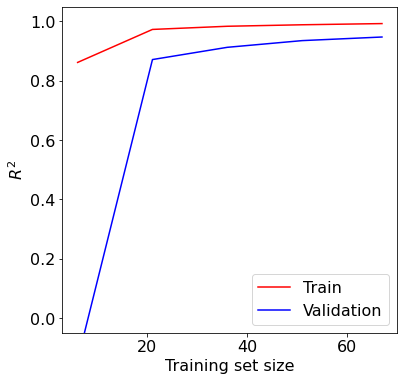

KernelRidge(alpha=1e-06, coef0=0.30612244904897956, gamma=0.001,
            kernel='polynomial')


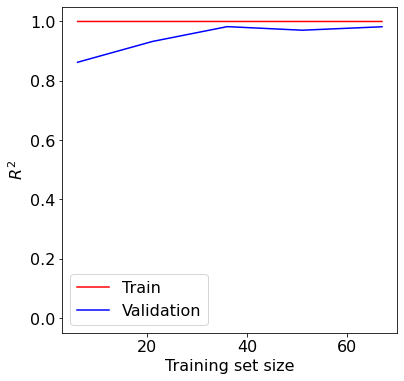

SVR(C=1000000, coef0=1.0, epsilon=1e-09, kernel='poly', max_iter=1000000,
    tol=1e-10)


Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


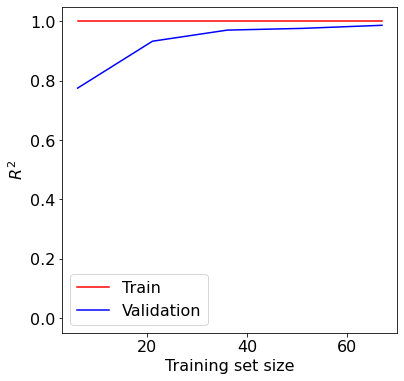

In [21]:
#Learning curves train vs. validation
for i in best_estim:
    print(i)
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(i, X_train_norm, y_train, cv=4,return_times=True, scoring='r2')
    fig, ax = plt.subplots(figsize=(6,6))
    plt.plot(train_sizes,np.mean(train_scores,axis=1), color='r', label='Train')
    plt.plot(train_sizes,np.mean(test_scores,axis=1), color='blue', label='Validation')
    plt.ylabel('$R^2$')
    plt.xlabel('Training set size')
    plt.ylim(-0.05,1.05)
    plt.legend()
    plt.show()
#     fig.savefig('learning curve {}.png'.format(i), dpi=300, bbox_inches = 'tight')


## Test the model on held-out data

RandomForestRegressor(max_depth=33, max_features='auto', min_samples_split=3,
                      n_estimators=322, random_state=42, warm_start=True)


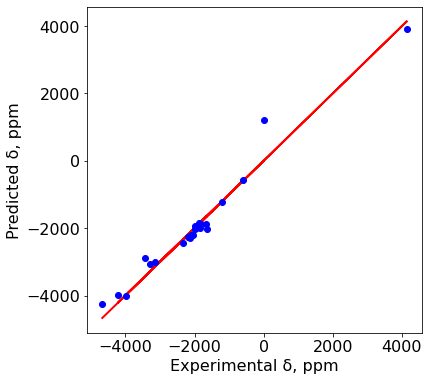

RMSE = 324.60 ppm 
 MAE = 200.14 ppm 
 $R**2$ = 0.96


KernelRidge(alpha=1e-06, coef0=0.30612244904897956, gamma=0.001,
            kernel='polynomial')


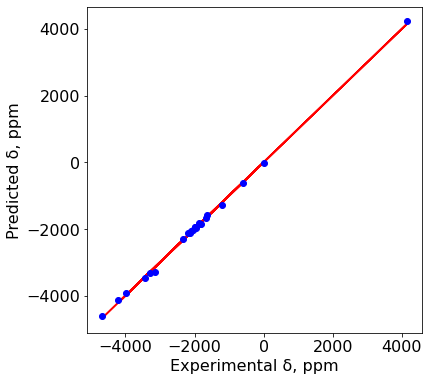

RMSE = 57.37 ppm 
 MAE = 46.81 ppm 
 $R**2$ = 1.00


SVR(C=1000000, coef0=1.0, epsilon=1e-09, kernel='poly', max_iter=1000000,
    tol=1e-10)


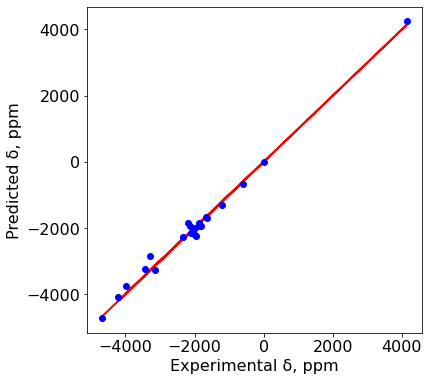

RMSE = 166.26 ppm 
 MAE = 127.48 ppm 
 $R**2$ = 0.99




In [22]:
for i in best_estim:
    print(i)
    plot_correlation(i, X_test_norm, y_test)
    print('\n')

## Models explanation

In [23]:
shap.initjs()
columns

Index(['Rho at Nucleus', 'DelSqRho', 'V', 'G', 'L', 'Vnuc', 'Ven', 'Vrep',
       'DelSqVen', 'DelSqVrep', 'DelSqK', 'ESP', 'ESPe', 'q(A)', 'L(A)',
       'K(A)', '|Mu_Intra(A)|', 'Molecular dipole'],
      dtype='object')

### Random Forest

In [24]:
explainer_rf = shap.TreeExplainer(model=best_estim[0])
shap_values_rf = explainer_rf.shap_values(X_train_norm[0])

shap.force_plot(base_value=explainer_rf.expected_value, shap_values=shap_values_rf,
                features=X_train_norm[0], feature_names=columns)

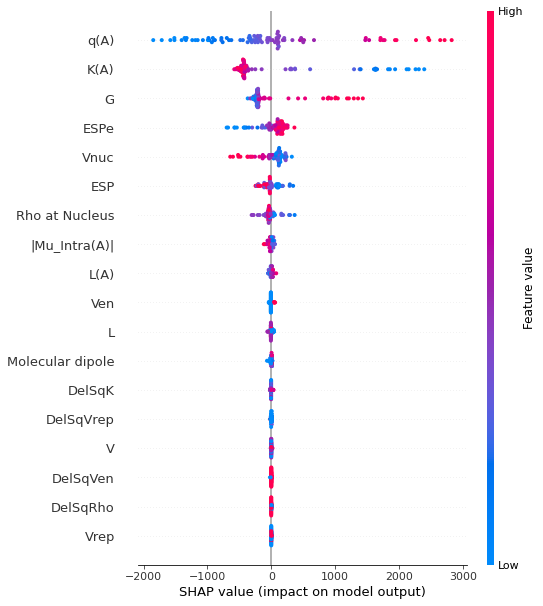

In [25]:
plt.rcParams['font.size'] = 16
explainer_rf = shap.TreeExplainer(model=best_estim[0])
shap_values_rf = explainer_rf(X_train_norm)
shap.summary_plot(shap_values_rf, X_train_norm, feature_names=columns, show=False)
plt.savefig('shap_random_forest.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

### Laplacian kernel ridge regression

In [26]:
explainer_ridge = shap.KernelExplainer(model=best_estim[1].predict, data=X_train_norm)
shap_values_ridge = explainer_ridge.shap_values(X_test_norm[0])

shap.force_plot(base_value=explainer_ridge.expected_value, shap_values=shap_values_ridge,
                features=X_test_norm[0], feature_names=columns)

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


  0%|          | 0/90 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

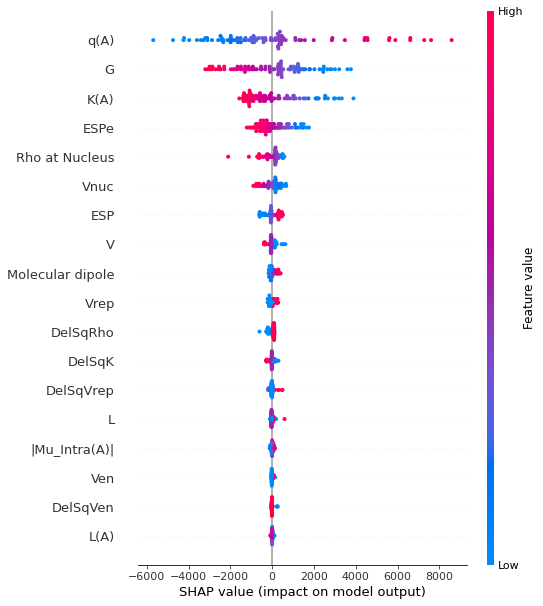

In [27]:
plt.rcParams['font.size'] = 16
shap_values_ridge = explainer_ridge.shap_values(X_train_norm)
shap.summary_plot(shap_values_ridge, X_train_norm, feature_names = columns, show=False)
# plt.savefig('shap_kernel.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

### SVR

In [28]:
explainer_svr = shap.KernelExplainer(model=best_estim[2].predict, data=X_train_norm)
shap_values_svr = explainer_svr.shap_values(X_train_norm[0])

shap.force_plot(base_value=explainer_svr.expected_value, shap_values=shap_values_svr,
                features=X_train_norm[0], feature_names=columns)

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


  0%|          | 0/90 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

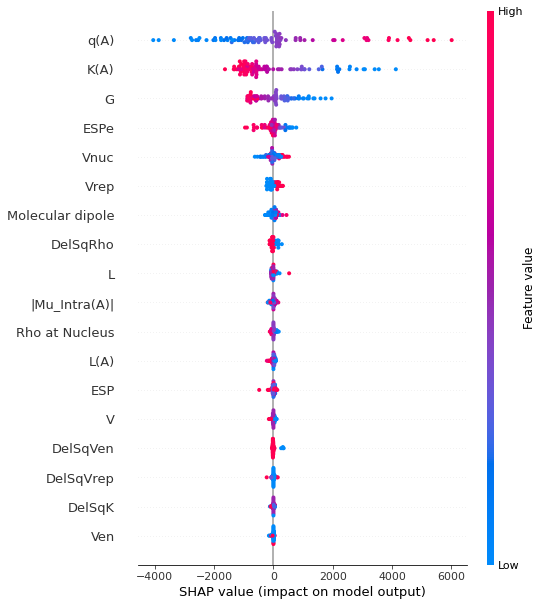

In [29]:
plt.rcParams['font.size'] = 16
shap_values_svr = explainer_svr.shap_values(X_train_norm)
shap.summary_plot(shap_values_svr, X_train_norm, feature_names = columns, show=False)
# plt.savefig('shap_svr.png', format='png', dpi=600, bbox_inches='tight')
plt.show()